# Pac-Man Analytics

With data collected from my [Final Year Project](https://github.com/Davidk20/pacman-solutions-backend), this is the statistical analysis of the different Pac-Man agents I have created. 

## Setup and Cleaning


- **"Standard Score"** - The score achieved by finishing a level. This involves consuming all pickups.
- **"Perfect Score"** - The score for achieving everything possible within a level. This involves catching all ghosts for each energiser consumed.
- **"Playable Spaces"** - The number of positions in which the agents can be.

In [10]:
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv("pacman_results.csv")

# Configure plot styling
plt.rcParams.update({
    'axes.labelsize': 8,   # X and Y label size
    'xtick.labelsize': 8,   # X tick label size
    'ytick.labelsize': 8,   # Y tick label size
    'legend.fontsize': 10,  # Legend font size
    'axes.titlesize': 12,    # Title size
})

# Removing the word "Pacman" to simplify labels.
df['agent_name'] = df['agent_name'].str.replace('PacMan', '')

# Extract the board_state and convert to a DataFrame
df['board_state'] = df['board_state'].apply(ast.literal_eval)
df['board_state'] = df['board_state'].apply(pd.DataFrame)

# The first level is used as the default board for initial analysis
default_board = df['board_state'].iloc[0]

standard_score = 0
standard_score += ((default_board.values == 1).sum() * 10)
standard_score += ((default_board.values == 2).sum() * 50)
perfect_score = standard_score + ((default_board.values == 2).sum() * 3000)
playable_spaces = np.isin(default_board.values, [0, 1, 2, 88, 21, 44]).sum()


# Find Pac-Man's position for each board state
def find_pacman(board_state):
    # Iterate over each row and column in the DataFrame
    for i, row in board_state.iterrows():
        for j, value in row.items():
            if value == 44:
                return (i, j)  # Return the position (row, column) of Pac-Man
    return None

df['pacman_pos'] = df['board_state'].apply(find_pacman)

Calculate the success rate of the different agents.

In [11]:
max_runs = 150
successful_runs = df.groupby('agent_name').agg(successful_runs=('run_id', 'nunique')).reset_index()
successful_runs['failed_runs'] = max_runs - successful_runs['successful_runs']
successful_runs['success_rate'] = round((successful_runs['successful_runs'] / max_runs), 2)
successful_runs.sort_values(by='success_rate', ascending=True)
successful_runs.head()

,agent_name,successful_runs,failed_runs,success_rate
0,Adventurous,142,8,0.95
1,Greedy,100,50,0.67
2,Inactive,150,0,1.00
3,Informed,150,0,1.00


## Scoring

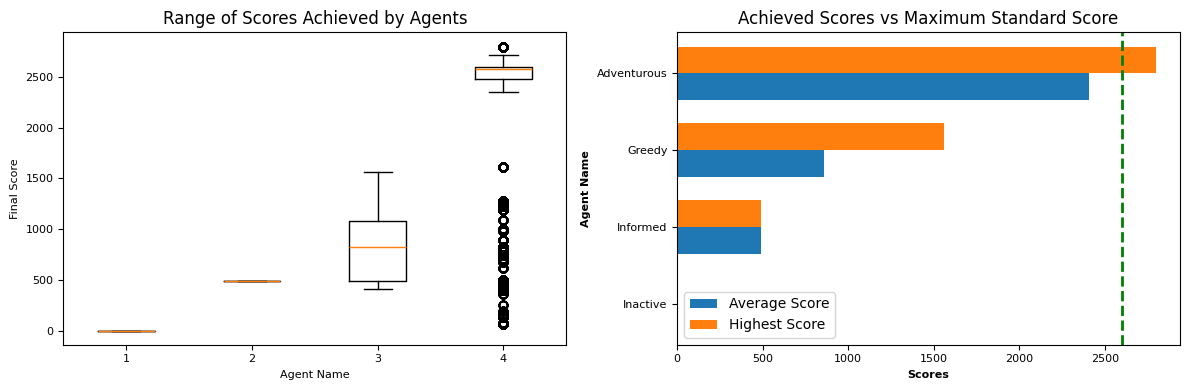

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.set_title('Range of Scores Achieved by Agents')
ax1.set_xlabel('Agent Name')
ax1.set_ylabel('Final Score')
ax1.boxplot([df[df['agent_name'] == agent]['final_score'] for agent in df['agent_name'].unique()])

avg_scores = df.groupby('agent_name')['final_score'].mean().reset_index().sort_values(by='final_score')
max_scores = df.groupby('agent_name')['final_score'].max().reset_index().sort_values(by="final_score")


ax2.set_title('Achieved Scores vs Maximum Standard Score')
ax2.set_xlabel('Level', fontweight='bold')
ax2.set_ylabel('Score', fontweight='bold')


bar_height = 0.35

# Set positions of the bars on the y-axis
r1 = range(len(avg_scores['agent_name']))
r2 = [x + bar_height for x in r1]

ax2.barh(r1, avg_scores['final_score'], height=bar_height, label='Average Score')
ax2.barh(r2, max_scores['final_score'], height=bar_height, label='Highest Score')

ax2.set_ylabel('Agent Name')
ax2.set_xlabel('Scores')
ax2.set_yticks([r + bar_height / 2 for r in range(len(avg_scores))], avg_scores['agent_name'])

max_score = ax2.axvline(x=standard_score, color='green', linestyle='--', linewidth=2)


# Find the count of rows where final_score equals 2600
complete_games = df[df['final_score'] == 2600].groupby('run_id').size().reset_index()


plt.legend()
plt.tight_layout()
plt.show()

- As expected, the inactive agent shows little variance as no score is ever achieved. 
- The unexpected result is the large variance in the results of the adventurous agent.
- In total, 7 runs of the Adventurous agent were able to achieve a score above the threshold for a completed level
  - It should be noted that this is possible as the agent will have also successfully consumed some ghosts, however further analysis is required to assess how many ghosts were consumed.

## Exploration

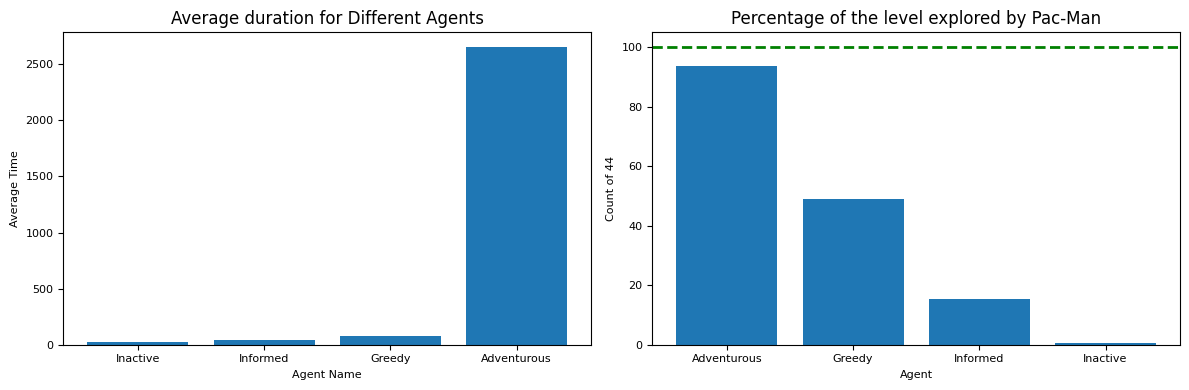

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))


# Calculate average time_ticks and final_score per agent
times = df.groupby('agent_name')['time_ticks'].mean().reset_index().sort_values(by='time_ticks')
ax1.bar(times["agent_name"], times["time_ticks"])


# Adding labels and title
ax1.set_xlabel('Agent Name')
ax1.set_ylabel('Average Time')
ax1.set_title('Average duration for Different Agents')


exploration = df.groupby('run_id').agg(
    agent_name=('agent_name', 'first'),  # Take the first agent_name per group
    pacman_pos=('pacman_pos', lambda x: len(x.unique()))  # Calculate unique positions per group
).reset_index().sort_values(by="pacman_pos", ascending=False)

exploration['positions_as_percent'] = (exploration['pacman_pos'] / playable_spaces) * 100



ax2.bar(exploration['agent_name'], exploration["positions_as_percent"])
ax2.axhline(y=100, color='green', linestyle='--', linewidth=2)
ax2.set_xlabel("Agent")
ax2.set_ylabel('Count of 44')
ax2.set_title("Percentage of the level explored by Pac-Man")


plt.tight_layout()
plt.show()

- As expected, the agents who are in-play for longer are able to explore a larger percent of the level. 
- The Greedy agent shows that a significant portion of the level can still be explored in a fraction of the time taken by the Adventurous agent.
  - As the adventurous agent survived longer, it will be unavoidable to have repeated paths and after a while there will be diminishing returns from the time traversing the map as there will be less new path to explore

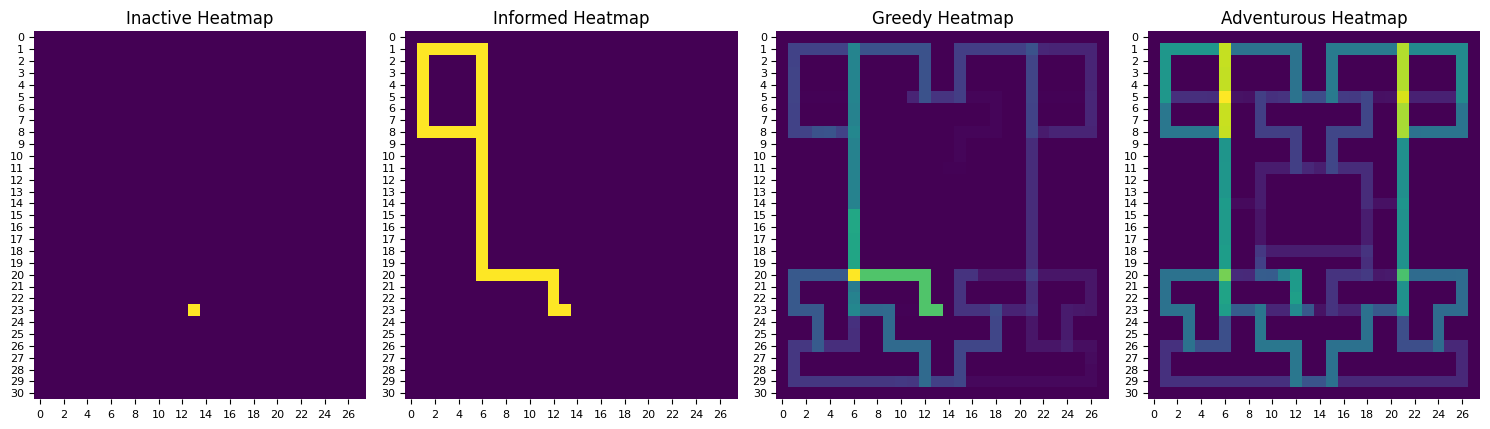

In [14]:
# Initialize an empty array to accumulate the counts
board_shape = np.array(df['board_state'].iloc[0]).shape  # assuming all boards have the same shape
heatmap = np.zeros(board_shape)

# List of unique agent names
agents = df['agent_name'].unique()

# Calculate number of rows and columns for subplot grid
num_agents = len(agents)
cols = num_agents
rows = (num_agents + 1) // cols

# Create a subplot row
fig, axs = plt.subplots(1, len(agents), figsize=(15, 5))

for i, agent in enumerate(agents):
    agent_df = df[df['agent_name'] == agent]
    board_shape = np.array(agent_df['board_state'].iloc[0]).shape
    heatmap = np.zeros(board_shape)
    
    for board in agent_df['board_state']:
        board_array = np.array(board)
        heatmap += (board_array == 44).astype(int)
    
    ax = axs[i]
    sns.heatmap(heatmap, annot=False, cmap='viridis', cbar=False, square=True, ax=ax)
    ax.set_title(f"{agent} Heatmap")

plt.tight_layout()
plt.show()

Notable findings:
- Informed agent appears to have one consistent route that it always follows
  - The set of rules when combined must lead to a single path each time no matter the condition
- Agents seem to prefer to go left from starting
- The Adventurous agent traverses almost the entire map and is the agent to explore the most of the map
  - It is interesting to note that the teleporter routes are never explored.

## Conclusions

- The adventurous agent is the most successful
  - The agent is very close to finishing the level in both traversal and point scoring